In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F



import os 
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

rebuild_data = False

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda: 0")
else:
    device = torch.device("cpu")
    
#i could assign specific layers to one gpu 

torch.cuda.device_count() #but i have only one :P
    

1

In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#in composed transforms leftmost applied first
#https://pytorch.org/docs/stable/torchvision/transforms.html

trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
dataiter = iter(trainloader)
dataiter.next()[0].shape 
#Four 32 by 32 r,g,b images


torch.Size([4, 3, 32, 32])

tensor([4, 6, 3, 0])
horse


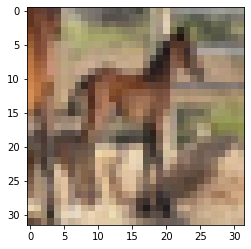

In [5]:
dataiter.next()[1].shape 
#labels of four images
print(dataiter.next()[1])

sampleImg4, label4 = dataiter.next()
img = sampleImg4[0]
label = label4[0]

img.shape

nimg = img.numpy()

nimg = nimg /2 + 0.5

plt.imshow(nimg.transpose(1,2,0)) #imshow wants x,y,rgb
print(classes[label])

In [6]:
#this is so low res seems stupid

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        #pool 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        #pool 2
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

     
    def forward(self, x):
        x = F.max_pool2d((F.relu(self.conv1(x))), 2)
        x = F.max_pool2d((F.relu(self.conv2(x))), 2)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   
    


In [8]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [11]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #batch of data 4 , 32x32, rgb
        
        optimizer.zero_grad()
        
        outputs = net(inputs.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i%2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss/ 2000))
            running_loss = 0.0
            
print("done training")



        

[1,  2000] loss: 2.206
[1,  4000] loss: 1.839
[1,  6000] loss: 1.673
[1,  8000] loss: 1.560
[1, 10000] loss: 1.527
[1, 12000] loss: 1.477
[2,  2000] loss: 1.414
[2,  4000] loss: 1.396
[2,  6000] loss: 1.359
[2,  8000] loss: 1.333
[2, 10000] loss: 1.312
[2, 12000] loss: 1.289
done training


In [14]:
savePath = './cifar_net.pth'
torch.save(net.state_dict(), savePath)

In [19]:
net2 = Net()

net.load_state_dict(torch.load(savePath))

<All keys matched successfully>

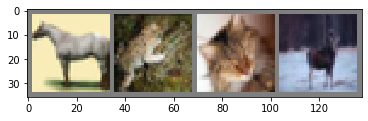

horse  frog   cat  deer


In [20]:


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
images.shape

torch.Size([4, 3, 32, 32])

In [22]:
outputs = net2(images)

In [23]:
outputs.shape
#for each image, 10 values

torch.Size([4, 10])

In [24]:
_, predicted = torch.max(outputs, 1)



In [25]:
predicted

tensor([5, 5, 5, 5])

In [26]:
predicted.shape

torch.Size([4])

In [27]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   dog   dog   dog


In [29]:
outputs.data.shape

torch.Size([4, 10])

In [31]:
net2 = net2.to(device)

In [34]:
labels.size(0)

4

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0) # = batch size 4
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [37]:
outputs.shape

torch.Size([4, 10])

In [49]:
(predicted == labels).squeeze()[0].item() 

2

In [51]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to("cuda")
        labels = labels.to("cuda")
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 72 %
Accuracy of  bird : 35 %
Accuracy of   cat : 54 %
Accuracy of  deer : 34 %
Accuracy of   dog : 49 %
Accuracy of  frog : 61 %
Accuracy of horse : 56 %
Accuracy of  ship : 65 %
Accuracy of truck : 49 %
